# Topological Sort

Topological sort is a way of sorting a Directed Acyclic Graph (DAG) such that each node comes before its dependent nodes.

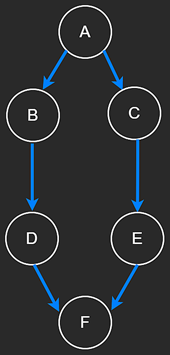

So if we have node `A` and it has node `B` and `C` as its dependents, then `A` must appear first before `B` and `C`. One topological ordering would be `A,B,C,D,E,F`, or `A,C,B,E,D,F`. Notice here that topo orders are not unique - both are valid ordering as long as the parent comes before the child.

*What if we had cycles?*

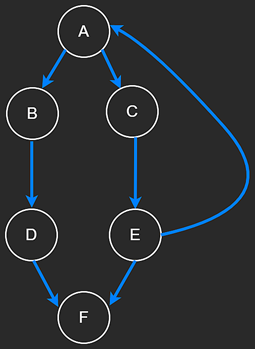

In a cycle, like `A->C->E->A...`, wqhich one is the parent and which is the child? That's why it doesn't make any sense to do topo sort on cycles.

*Disconnected Graphs*

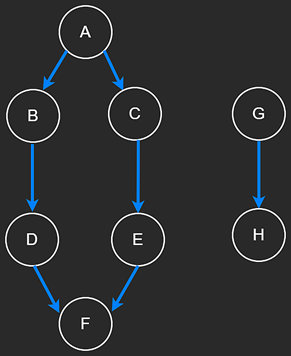

Topo sort will still work on disconnected graphs. Given 2 disconected portions, the order in which we place them does not matter, as long as each parent comes before its child. In this example, `ABCDEFGH` and `ABCGDEHF` are both valid, but not `ABCGDEFH`.




## The Algorithim

To traverse the graph, we can either use BFS or DFS. Here we will use DFS. It seems like the head `A` is a good place to start, and we want to return at `F` where there are no more children (dependents). If we do naive DFS, we end up hitting `F` twice because there are 2 ways we can reach it. Hence we use a `visit` hashset to keep track of visited nodes, and make sure there are no repeats.

Let's try preorder traversal - we get `ABDFCEGH`. This is problematic because we've visited `F` before visiting `C,E`.

We want to find a way so we can visit `C,E` first before visiting `F`. We actually do this using postorder DFS, plus some sort of order reversal. We present 2 techniques.

**1. PostOrder DFS + Reverse Resultant Array**

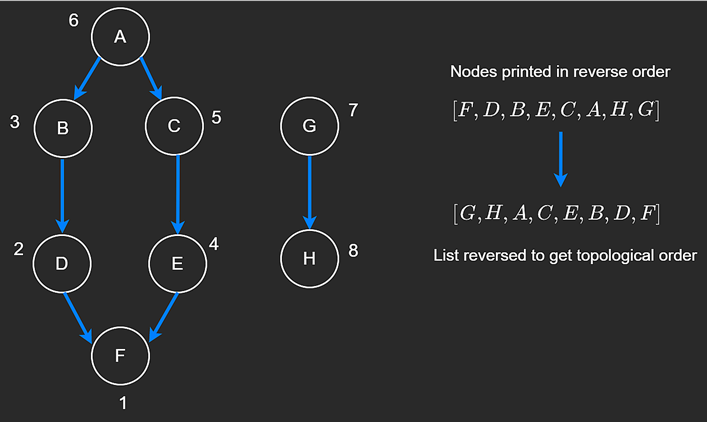

The output of postorder DFS is technically correct, just need to reverse the array

**2. Reverse Edges + PostOrder DFS**

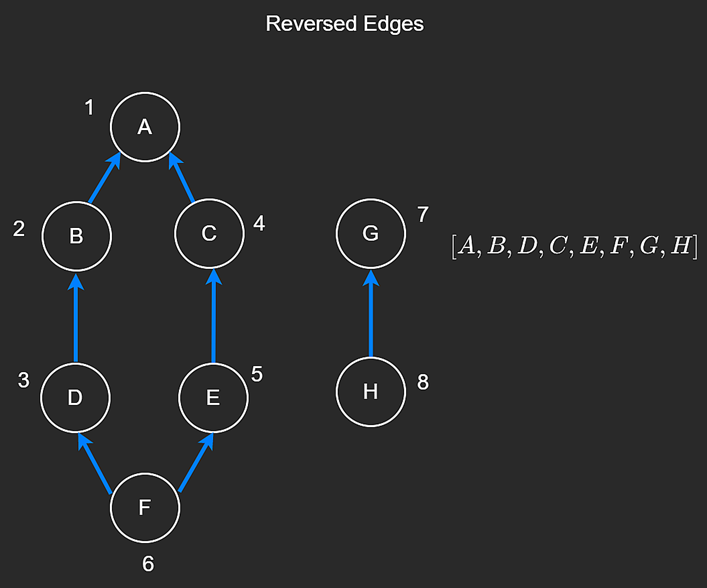

> Note that trying InOrder DFS will give us a completely wrong result - `FDBAECHG` which is not very useful at all. This is because the root node `A` is in the 'middle', while we want it at the start, or at the end where we can flip it to the start.
>
> In Python, we can either use slicing `list[::-1]` which creates a copy of the list and doesnt modify it. This is $O(n)$ time and $O(n)$ space.
>
> We can also do `list.reverse()` which does reversing in-place. This is $O(n)$ time and $O(1)$ space.

## Topological Sort Without a Known Starting Point

In the above examples, we intuitively knew the 'root' nodes and started from there. However, as long as we have a *complete list* of all the nodes, we can simply run PostOrder DFS on each of the nodes in the list, appending visited nodes to our results in real-time. At the end, after we've visited all nodes, we then reverse the list.

Suppose our given list of nodes goes like `B,C,H,A.....`. Then, we first run postorder DFS on `B`, and its visited nodes in real time. We then do postorder DFS on `C`, `H`, `A` respectively.

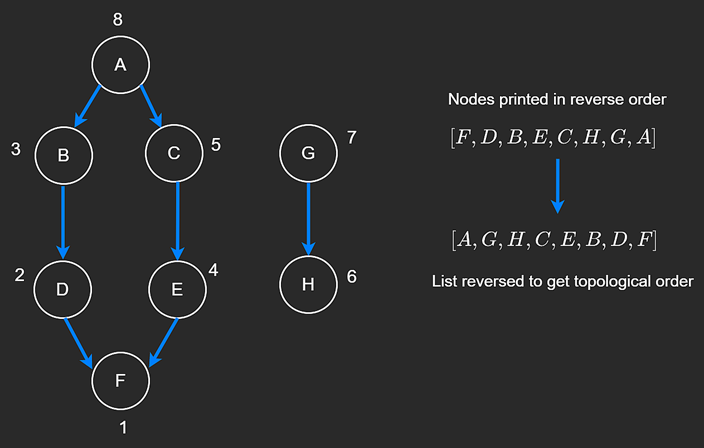

We can see that despite having a 'wrong' starting point of `B` instead of the root `F`, we still end up with the correct traversal. This is because postorder means the final nodes (with no children) will always be printed first, so it doesn't matter where we start.

## Implementation

First we build our adjacency list for easy of traversal To store our topological ordering, we can use a list `topSort` and append to it in real-time. We also use `visit` hashset to avoid revisiting the same node twice.

**DFS**

We pass in `src` which is the current node we're considering. If it is already in `visit`, we can simply return as we've done this route and everything after before. Otherwise, we can add it to `visit` and perform `dfs` on its neighbours. Only *after* performing `dfs` on its neighbours (children), we then append `src` to `topSort` - this is postOrder DFS.

In [ ]:
# Given a directed acyclical graph, return a valid
# topological ordering of the graph.
def topologicalSort(edges, n):

    #build adjacency list
    adj = {}
    for i in range(1, n + 1):
        adj[i] = []
    for src, dst in edges:
        adj[src].append(dst)

    topSort = []
    visit = set()

    #go through all the nodes and do DFS on each
    for i in range(1, n + 1):
        dfs(i, adj, visit, topSort)
    #final step is to reverse
    topSort.reverse()
    return topSort

def dfs(src, adj, visit, topSort):
    if src in visit:
        #doesnt matter what you return here, just terminate this call stack
        return
    #we can visit immediately before doing DFS on its neighbours! This part is kinda like preorder
    visit.add(src)

    #perform dfs on all its neighbours
    for neighbor in adj[src]:
        dfs(neighbor, adj, visit, topSort)

    #postOrder operation after doing DFS on neighbours
    topSort.append(src)


**Cyclical Path**

What if we were not guaranteed that the graph was acyclic? How would we go about adding cycle detection to our graph? We simply declare another hashset `path` which keeps track of our current path in DFS. However, each time we pop from the recursion stack, we will also pop from `path`. If we ever visit the same vertex along a path twice, we can return false as it means theres a cycle.

In neetcode's implementation:
- DFS returns `True` if no cycle is detected and `False` if a cycle is detected.
- DFS also modifies both `visit` and `path` in real-time
  - somehow for their implementation `visit` must be marked only AFTER the children have been visited

In [ ]:
from collections import defaultdict

class Solution:
    def topologicalSort(self, n: int, edges: List[List[int]]) -> List[int]:
        adj = defaultdict(list)
        for src, dst in edges:
            adj[src].append(dst)

        topSort = []
        visit = set()  # Visited nodes
        path = set() # Nodes being visited in the current DFS call (used to detect cycles)
        
        def dfs(src: int) -> bool:
            if src in visit:
                return True
            if src in path:
                return False  # A cycle is detected
            
            path.add(src)
            
            for neighbor in adj[src]:
                if not dfs(neighbor):
                    return False  # A cycle is detected
                
            path.remove(src)
            #this is interesting!
            #the visit marking step can be done after children are visited, or marked before
            visit.add(src)
            topSort.append(src)
            
            return True  # No cycle detected

        for i in range(n):
            if not dfs(i):
                return []  # Return an empty list if a cycle is detected
        
        topSort.reverse()
        return topSort


my implementation uses `visit` and `path` as an argument to every call
- For this, I can add to `visit` either before exploring children or after adding children. I'm still not sure why the behaviour is different from Neetcode's implementation.

However, I think in theory adding to `visit` after exploring children, in other words at the same time we add it to `topo`, makes more sense

In [ ]:

#my implementation without returning True if no cycle is detected.
class Solution:
    def topologicalSort(self, n: int, edges: List[List[int]]) -> List[int]:
        #build adjacency list
        adj={}
        for i in range(n):
            adj[i]=[]
        for u,v in edges:
            adj[u].append(v)

        #set DFS
        visit=set()
        topoSort=[]

        def post(src, visit, path, topo):
            #check if cycle exists first
            if src in path:
                return False
            
            #check if visited already or not
            if src in visit:
                return
            print('pretraverse',src)
            visit.add(src)
            path.add(src)

            #dfs on neighbours
            for nei in adj[src]:
                print('path is',path)
                if post(nei, visit, path, topo)==False:
                    print('cycle detected!')
                    return False
            
            #finished traversal, remove from path and
            print('posttraverse, adding to topo',src)
            path.remove(src)
            topo.append(src)
        
        for node in range(n):
            #visit is always modified in time
            #path is reset everytime
            if post(src=node, visit=visit, path=set(), topo=topoSort)==False:
                return []

        topoSort.reverse()

        return topoSort